<a href="https://colab.research.google.com/github/sthalles/SimCLR/blob/simclr-refactor/feature_eval/mini_batch_logistic_regression_evaluator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

## Basic Imports

In [1]:
import torch
import sys
import numpy as np
import os
import yaml
import matplotlib.pyplot as plt
import torchvision

/nethome/achen353/anaconda3/envs/morphclr/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Download Datasets

In [ ]:
! pip install gdown

In [2]:
def get_file_id_by_model(folder_name):
    file_id = {
        "resnet18_100-epochs_stl10": "14_nH2FkyKbt61cieQDiSbBVNP8-gtwgF",
        "resnet18_100-epochs_cifar10": "1lc2aoVtrAetGn0PnTkOyFzPCIucOJq7C",
        "resnet50_50-epochs_stl10": "1ByTKAUsdm_X7tLcii6oAEl5qFRqRMZSu",
    }
    return file_id.get(folder_name, "Model not found.")

In [3]:
folder_name = "resnet50_50-epochs_stl10"
file_id = get_file_id_by_model(folder_name)
print("Folder Name: ", folder_name)
print("File ID: ", file_id)

Folder Name:  resnet50_50-epochs_stl10
File ID:  1ByTKAUsdm_X7tLcii6oAEl5qFRqRMZSu


In [4]:
# download and extract model files
pretrained_weights_dir = "./simclr_pretrained_weights"
gdrive_url = "https://drive.google.com/uc?id={}".format(file_id)
folder_full_name = os.path.join(pretrained_weights_dir, folder_name)

if not os.path.exists(pretrained_weights_dir):
    os.makedirs(pretrained_weights_dir)

os.system("cd {} && gdown {}".format(pretrained_weights_dir, gdrive_url))
os.system("unzip {} -d {}".format(folder_full_name, folder_full_name))
os.system("ls {}".format(folder_full_name))

Downloading...
From: https://drive.google.com/uc?id=1ByTKAUsdm_X7tLcii6oAEl5qFRqRMZSu
To: /home/achen353/MorphCLR/feature_eval/simclr_pretrained_weights/resnet50_50-epochs_stl10.zip
100%|██████████| 277M/277M [00:00<00:00, 417MB/s] 


Archive:  ./simclr_pretrained_weights/resnet50_50-epochs_stl10.zip
checkpoint_0040.pth.tar
config.yml
events.out.tfevents.1610927742.4cb2c837708d.2694093.0
lr_checkpoint_0100.pth.tar
training.log


replace ./simclr_pretrained_weights/resnet50_50-epochs_stl10/checkpoint_0040.pth.tar? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


0

## Load the Finetuned Checkpoint

In [5]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets

In [6]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cuda:1"
print("Using device:", device)

Using device: cuda:1


In [7]:
def get_stl10_data_loaders(download, shuffle=False, batch_size=256):
    train_dataset = datasets.STL10(
        "./data", split="train", download=download, transform=transforms.ToTensor()
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=0,
        drop_last=False,
        shuffle=shuffle,
    )

    test_dataset = datasets.STL10(
        "./data", split="test", download=download, transform=transforms.ToTensor()
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=1,  # batch_size = 1 instead of 2 * batch_size
        num_workers=10,
        drop_last=False,
        shuffle=shuffle,
    )
    return train_loader, test_loader


def get_cifar10_data_loaders(download, shuffle=False, batch_size=256):
    train_dataset = datasets.CIFAR10(
        "./data", train=True, download=download, transform=transforms.ToTensor()
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=0,
        drop_last=False,
        shuffle=shuffle,
    )

    test_dataset = datasets.CIFAR10(
        "./data", train=False, download=download, transform=transforms.ToTensor()
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=1,  # batch_size = 1 instead of 2 * batch_size
        num_workers=10,
        drop_last=False,
        shuffle=shuffle,
    )
    return train_loader, test_loader

In [8]:
with open(os.path.join(folder_full_name, "./config.yml")) as file:
    config = yaml.load(file, Loader=yaml.UnsafeLoader)

In [9]:
if config.arch == "resnet18":
    model = torchvision.models.resnet18(pretrained=False, num_classes=10).to(device)
elif config.arch == "resnet50":
    model = torchvision.models.resnet50(pretrained=False, num_classes=10).to(device)

/nethome/achen353/anaconda3/envs/morphclr/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/nethome/achen353/anaconda3/envs/morphclr/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [10]:
checkpoint = torch.load(
    os.path.join(folder_full_name, "lr_checkpoint_0100.pth.tar"), map_location=device
)
state_dict = checkpoint["state_dict"]

In [11]:
log = model.load_state_dict(state_dict, strict=False)

In [12]:
if config.dataset_name == "cifar10":
    train_loader, test_loader = get_cifar10_data_loaders(download=True)
elif config.dataset_name == "stl10":
    train_loader, test_loader = get_stl10_data_loaders(download=True)
print("Dataset:", config.dataset_name)

Files already downloaded and verified
Files already downloaded and verified
Dataset: stl10


In [13]:
criterion = torch.nn.CrossEntropyLoss().to(device)

# Test Adversarial Examples

In [14]:
import torch.nn.functional as F

In [15]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [16]:
def test_adversarial(model, device, test_loader, epsilon):
    # Accuracy counter
    correct = 0
    adv_examples = []

    # Important: Set model to eval(), otherwise the dropout might cause the result inaccurate
    model.eval()

    # Loop over all examples in test set
    for data, target in test_loader:
        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[
            1
        ]  # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = criterion(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[
            1
        ]  # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))

    # Calculate final accuracy for this epsilon
    final_acc = correct / float(len(test_loader))
    print(
        "Epsilon: {}\tTest Accuracy = {} / {} = {}".format(
            epsilon, correct, len(test_loader), final_acc
        )
    )

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [19]:
adv_epsilons = [0, 0.01, 0.02, 0.03, 0.04, 0.05]

adv_accuracies = []
adv_examples = []

# Run test for each epsilon
for eps in adv_epsilons:
    acc, ex = test_adversarial(model, device, test_loader, eps)
    adv_accuracies.append(acc)
    adv_examples.append(ex)

Epsilon: 0	Test Accuracy = 5366 / 8000 = 0.67075
Epsilon: 0.01	Test Accuracy = 1400 / 8000 = 0.175
Epsilon: 0.02	Test Accuracy = 611 / 8000 = 0.076375
Epsilon: 0.03	Test Accuracy = 321 / 8000 = 0.040125
Epsilon: 0.04	Test Accuracy = 199 / 8000 = 0.024875
Epsilon: 0.05	Test Accuracy = 150 / 8000 = 0.01875


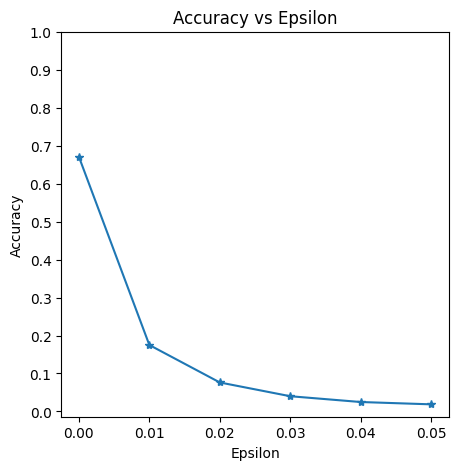

In [21]:
plt.figure(figsize=(5, 5))
plt.plot(adv_epsilons, adv_accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 0.06, step=0.01))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

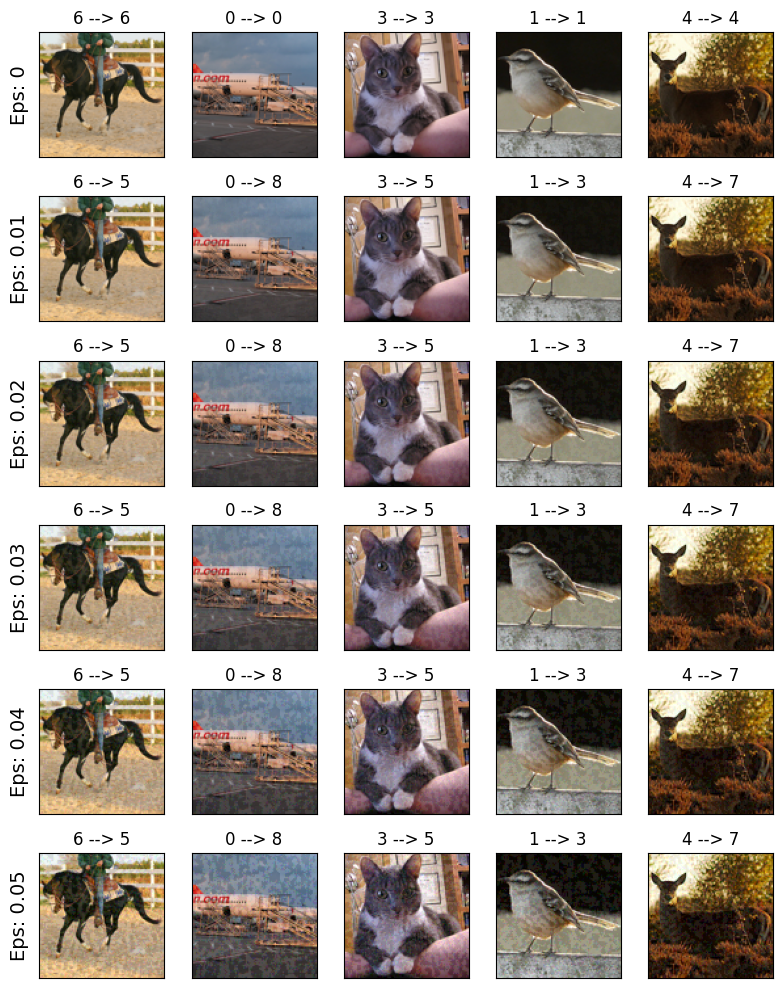

In [28]:
classes = [
    "airplane",
    "bird",
    "car",
    "cat",
    "deer",
    "dog",
    "horse",
    "monkey",
    "ship",
    "truck",
]
cnt = 0
plt.figure(figsize=(8, 10))
for i in range(len(adv_epsilons)):
    for j in range(len(adv_examples[i])):
        cnt += 1
        plt.subplot(len(adv_epsilons), len(adv_examples[0]), cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(adv_epsilons[i]), fontsize=14)
        orig, adv, ex = adv_examples[i][j]
        plt.title("{} --> {}".format(orig, adv))
        plt.imshow(ex.transpose(1, 2, 0))
plt.tight_layout()
plt.show()